# Semantic Network
## Semantic Network란?
원래 AI에서 Semantic Network란 지식의 표현과 관계를 나타내기 위해서 만들어진 개념이다. 과학 분야에서의 여러가지 개념들을 연결해서 설명하기 위해 만들어진 구조로 1968년에 제안되어 오랜기간 사용되었다.

![example of semantic network](figs/semantic_network.jpg)

이 그림에서 보면 각 개체(object, node)별로의 관계가 link(edge, relationship)에 정의되어 있다. 이러한 구조를 발전된 Graph Theory와 Visual Text Analytics, Network Analysis 이론들과 결합하여 "Semantic Network Analysis as a Method for Visual Text Analytics(9th Conference on Applications of Social Network Analysis, 2013)" 논문에 처음으로 text mining을 위한 시각화 방법으로 제안되었다.

![figure of semantic network](figs/semantic_network_paper.png)

## Semantic Network Analysis의 절차

데이터가 text이지만, 전반적인 Network Analysis의 절차를 그대로 따른다.

![semantic network process](figs/network_analysis_process.png)

>위의 다이어그램은 Jana Diesner의 Semantic Network Analysis Tutorial 자료에서 가져온 것이다.

### Text Mining을 위한 semantic network build step

기존의 network analysis 방법에서, text data를 위해서 새롭게 network를 정의해주어야 한다. 그에 따라 방법이 추가된다.

#### 1. Text Preprocessing

> 이 과정에는 stemming, lemmatization, text normalization 등 여러가지 text를 사용하기 위한 전처리 작업이 필요하다.

#### 2. Node identification

> 모든 network analysis에서 가장 중요한 것은, node를 어떻게 정의하느냐이다. 문서 전체를 하나의 노드로 만들 수도 있고, n-gram이나 단어 하나를 노드로 만들 수도 있다. 요즘에는 word embedding vector를 사용하기도 한다.

#### 3. Edge identification

> node의 정의에 따라, 맞는 edge를 정의해주어야 한다. text data를 사용하는 network analysis에서는 edge의 정의에 따라 완전히 다른 결과가 나오게 된다. 보통은 text mining에서 사용하는 여러가지 similarity를 사용한다. (e.g. cosine similarity, euclidean distance, word relationship, ontology-based distance 등)

## 텍스트 정제를 위해 불용어를 정의하고, 데이터에 적용합니다.

In [1]:
#불용어들을 추가합니다. 국립언어원 공식 한국어불용어 100개와 추가하고싶은 단어들을 추가합니다. 기본적으로 공백과, 특수문자들을 제거했습니다.

import string

SW = set()
SW.add(" ")
SW.add("○")
for i in string.punctuation:
    SW.add(i)

with open("data/한국어불용어100.txt", 'r', encoding="utf-8") as f:
    for line in f:
        stop_word = line.split()[0]
        SW.add(stop_word)

## 어휘 네트워크를 이용한 토픽 모델의 시각화
* 위 스크립트를 앞선 강의에서 살펴본 어휘 공기 네트워크 분석 기법과 결합하면 토픽들을 관통하는 키워드들의 연결 구조를 살펴볼 수 있다.
* 토픽모델링은 텍스트 자체를 사용하므로, word embedding된 벡터를 사용할 수 없다.
* 그 방법으로 제시된 방법이 LDA2Vec가 있으나, 방식을 이해하기 힘드므로, 일단은 co-occurence를 이용하여 semantic network를 구성하여 본다.


Building document-term matrix.
Doc num: 0
	0	0.8371843099594116
	1	0.023502958938479424
	2	0.11991961300373077
	3	0.019393129274249077
Building topic word co-occurrence matrix.
Generating topic word documents.
Sorting topic word occurrence.
Generating topic word co-occurrence network.
Drawing topic word network.


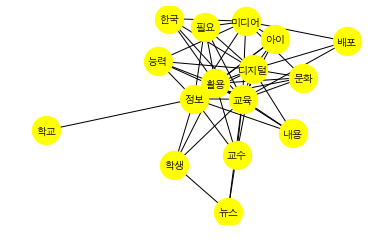

In [8]:
import sys
from collections import defaultdict
from collections import Counter
from itertools import combinations
from operator import itemgetter
from gensim import corpora
from gensim import models
from summa import keywords

from gensim.models import TfidfModel

import networkx as nx
from konlpy.tag import Mecab
from tqdm import tqdm_notebook
import warnings
warnings.simplefilter("ignore")

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

tfidf_mode = False
textrank = True
NUM_TOPICS = 4
NUM_TOPIC_WORDS = 30
NUM_WORD_COOCS = 50


def read_documents(input_file_name):
    """문서들을 주어진 이름의 파일로부터 읽어들여 돌려준다."""
    
    corpus = []

    with open(input_file_name, "r", encoding="cp949") as input_file:
        for line in input_file:
            #line 하나가 문서 하나를 의미.
            corpus.append(line)

    return corpus


def text_tokenizing(corpus, tokenizer):
    
    token_corpus = []
    
    if tokenizer == "noun":
        mecab = Mecab()

        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = mecab.nouns(corpus[n])
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            
            if textrank:
                token_text = keywords.keywords(" ".join(token_text)).split('\n')
            token_corpus.append(token_text)

        #print(token_corpus[:5])
        
    elif tokenizer == "word":

        for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
            token_text = corpus[n].split()
            token_text = [word for word in token_text if word not in SW and len(word) > 1]
            token_corpus.append(token_text)
            
#     elif tokenizer == "textRank":
#         for n in tqdm_notebook(range(len(corpus)), desc="Preprocessing"):
#             token_text = keywords.keywords(corpus[n]).split('\n')
#             #print(token_text)
#             #print(type(token_text))
#             token_text = [word for word in token_text if word not in SW and len(word) > 1]
#             token_corpus.append(token_text)

        print(token_corpus[:5])
        

    return token_corpus

def build_doc_term_mat(documents):
    """주어진 문서 집합으로 문서-어휘 행렬을 만들어 돌려준다."""
    
    print_log_msg("Building document-term matrix.")
    dictionary = corpora.Dictionary(documents)
    temp_corpus = [dictionary.doc2bow(document) for document in documents]
    
    if tfidf_mode:
        tfidf = TfidfModel(temp_corpus)
        corpus = tfidf[temp_corpus]

    else:
        corpus = temp_corpus

    return corpus, dictionary


def build_word_cooc_mat(model):
    """주어진 토픽 모델링 결과에서 어휘 공기 행렬을 생성하여 돌려준다."""
    
    print_log_msg("Building topic word co-occurrence matrix.")
    word_cooc_mat = defaultdict(Counter)
    topic_documents = get_topic_documents(model)
    
    for topic_document in topic_documents:
        for word1, word2 in combinations(topic_document, 2):
            word_cooc_mat[word1][word2] += 1
            
    return word_cooc_mat
    
    
def get_topic_documents(model):
    """주어진 토픽 모델링 결과에서 토픽 문서를 생성하여 돌려준다."""
    
    print_log_msg("Generating topic word documents.")
    topic_documents = []
    
    for topic_id in range(model.num_topics):
        topic_document = []
        topic_word_probs = model.show_topic(topic_id, NUM_TOPIC_WORDS)

        for topic_word, prob in topic_word_probs:
            topic_document.append(topic_word)
            
        topic_documents.append(topic_document)
        
    return topic_documents


def build_word_cooc_network(sorted_word_coocs):
    """토픽 단어 공기 네트워크를 생성하여 돌려준다."""
    
    print_log_msg("Generating topic word co-occurrence network.")
    G = nx.Graph()

    for word1, word2, count in sorted_word_coocs[:NUM_WORD_COOCS]:
        G.add_edge(word1, word2, weight=count)
        
    #T = nx.minimum_spanning_tree(G)

    return G


def get_sorted_word_coocs(word_cooc_mat):
    """주어진 어휘 공기 행렬에서 공기 빈도로 역술 정렬된 행렬을 생성하려 돌려준다."""
    
    print_log_msg("Sorting topic word occurrence.")
    word_coocs = []
    
    for word1, word2_counter in word_cooc_mat.items():
        for word2, count in word2_counter.items():
            word_coocs.append((word1, word2, count))
            
    sorted_word_coocs = sorted(word_coocs, key=itemgetter(2), reverse=True)
    
    return sorted_word_coocs


def draw_network(G):
    """주어진 어휘 공기 네트워크를 화면에 표시한다."""
    
    print_log_msg("Drawing topic word network.")
    font_name = get_font_name()
    nx.draw_networkx(G,
            pos=nx.spring_layout(G, k=0.5, scale=4),
            node_size=800,
            node_color="yellow",
            font_family=font_name,
            label_pos=0,  # 0=head, 0.5=center, 1=tail
            with_labels=True,
            font_size=10)

    plt.axis("off")
    if tfidf_mode:
        plt.savefig("tfidf_graph.png")
    else:
        plt.savefig("bow_graph.png")
    plt.show()
    
    
def get_font_name():
    """플랫폼에 따라 화면에 표시할 글꼴 이름을 돌려준다."""
    
    if sys.platform in ["win32", "win64"]:
        font_name = "malgun gothic"
    elif sys.platform == "darwin":
        font_name = "AppleGothic"
        
    return font_name


def print_document_topics(model, corpus):
    """주어진 토픽 모델링 결과와 문서 어휘 행렬에서 문서별 토픽 분포를 출력한다."""
    
    for doc_num, doc in enumerate(corpus):
        topic_probs = model[doc]
        print("Doc num: {}".format(doc_num))

        for topic_id, prob in topic_probs:
            print("\t{}\t{}".format(topic_id, prob))
            
        break

        print("\n")


def print_log_msg(msg):
    """로그 메시지를 출력한다."""
    
    print(msg, flush=True)
        
        

input_file_name = "data/naver_news_digital_literacy(2581개).txt"
documents = read_documents(input_file_name)
tokenized_documents = text_tokenizing(documents, tokenizer="noun") #tokenizer= "noun" or "word"
corpus, dictionary = build_doc_term_mat(tokenized_documents)
model = models.ldamodel.LdaModel(corpus, num_topics=NUM_TOPICS,
                                 id2word=dictionary,
                                 alpha='auto',
                                 passes=100)
print_document_topics(model, corpus)
word_cooc_mat = build_word_cooc_mat(model)
sorted_word_coocs = get_sorted_word_coocs(word_cooc_mat)
G = build_word_cooc_network(sorted_word_coocs)
draw_network(G)

In [6]:
pyLDAvis.enable_notebook()

data = pyLDAvis.gensim.prepare(model, corpus, dictionary)
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.332598  0.000846       1        1  42.874115
3      0.115029  0.072890       2        1  24.674303
0      0.109421 -0.101140       3        1  16.352253
1      0.108148  0.027404       4        1  16.099327, topic_info=     Category         Freq    Term        Total  loglift  logprob
term                                                             
13    Default  5004.000000          5004.000000  30.0000  30.0000
3     Default    63.000000     디지털    63.000000  29.0000  29.0000
6257  Default    32.000000      아츠    32.000000  28.0000  28.0000
234   Default    29.000000     어린이    29.000000  27.0000  27.0000
1     Default    54.000000      교육    54.000000  26.0000  26.0000
109   Default    36.000000      배포    36.000000  25.0000  25.0000
55    Default    40.000000      뉴스    40.000000  24.0000  24.0000
61    Default    40.000000     미디어    40.000000  23.0000  23.0000
1849  Default    24.000000      시각    24.000000  22.0000  22.0000
90    Default    35.000000      문화    35.000000  21.0000  21.0000
119   Default    20.000000     투데이    20.000000  20.0000  20.0000
137   Default    34.000000      게임    34.000000  19.0000  19.0000
3872  Default    19.000000  디지털 기기    19.000000  18.0000  18.0000
25    Default    35.000000      정보    35.000000  17.0000  17.0000
6066  Default    16.000000      넥슨    16.000000  16.0000  16.0000
379   Default    13.000000      부산    13.000000  15.0000  15.0000
12    Default    31.000000      활용    31.000000  14.0000  14.0000
1376  Default    16.000000     컴퓨터    16.000000  13.0000  13.0000
1382  Default    13.000000      포럼    13.000000  12.0000  12.0000
3875  Default    11.000000     헤럴드    11.000000  11.0000  11.0000
2     Default    22.000000      능력    22.000000  10.0000  10.0000
136   Default    29.000000    프로그램    29.000000   9.0000   9.0000
70    Default    23.000000      언론    23.000000   8.0000   8.0000
389   Default    18.000000      개인    18.000000   7.0000   7.0000
139   Default    22.000000      기술    22.000000   6.0000   6.0000
169   Default    11.000000     트위터    11.000000   5.0000   5.0000
373   Default    20.000000      과정    20.000000   4.0000   4.0000
73    Default    21.000000      한국    21.000000   3.0000   3.0000
219   Default    19.000000     유튜브    19.000000   2.0000   2.0000
153   Default    15.000000      저작    15.000000   1.0000   1.0000
...       ...          ...     ...          ...      ...      ...
972    Topic4     3.499757      영리     4.576858   1.5581  -6.5345
358    Topic4     3.735795      폭력     4.932741   1.5485  -6.4692
109    Topic4    22.183926      배포    36.281548   1.3345  -4.6878
1010   Topic4     3.186751     이사장     4.182452   1.5545  -6.6282
133    Topic4     6.406681      구글     9.413069   1.4416  -5.9299
1472   Topic4     5.040294      매체     7.255473   1.4621  -6.1697
90     Topic4    18.202953      문화    35.365707   1.1622  -4.8856
139    Topic4    12.166533      기술    22.303188   1.2204  -5.2885
708    Topic4     7.232131      산업    11.730957   1.3427  -5.8087
1      Topic4    23.449219      교육    54.253403   0.9876  -4.6324
77     Topic4    10.694983      방송    19.837502   1.2086  -5.4174
59     Topic4     8.388167      시대    15.032781   1.2430  -5.6604
73     Topic4    10.971957      한국    21.984291   1.1314  -5.3919
1761   Topic4     5.949323      기기     9.653420   1.3424  -6.0039
179    Topic4     7.468158      영상    13.365438   1.2444  -5.7765
170    Topic4     5.592507     한겨레     8.871912   1.3649  -6.0658
496    Topic4     6.537757      미래    11.439245   1.2669  -5.9096
734    Topic4     5.194794      시장     8.859390   1.2926  -6.1395
380    Topic4     6.903955     서비스    14.491707   1.0849  -5.8551
1125   Topic4     4.087099      가능     6.264163   1.3994  -6.3794
373    Topic4     7.168893      과정    20.711079   0.7655  -5.8174
103    Topic4     5.101575      지역    10.262138   1.1275  -6.1576
12 